In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

import os
MODELOS_DIR = os.path.abspath(DATOS_DIR+'../MODELOS/')

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Cargar imagenes de MNIST

In [2]:
from tensorflow import keras
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

2025-07-03 22:13:38.346807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Diagrama de Autoencoder Variacional
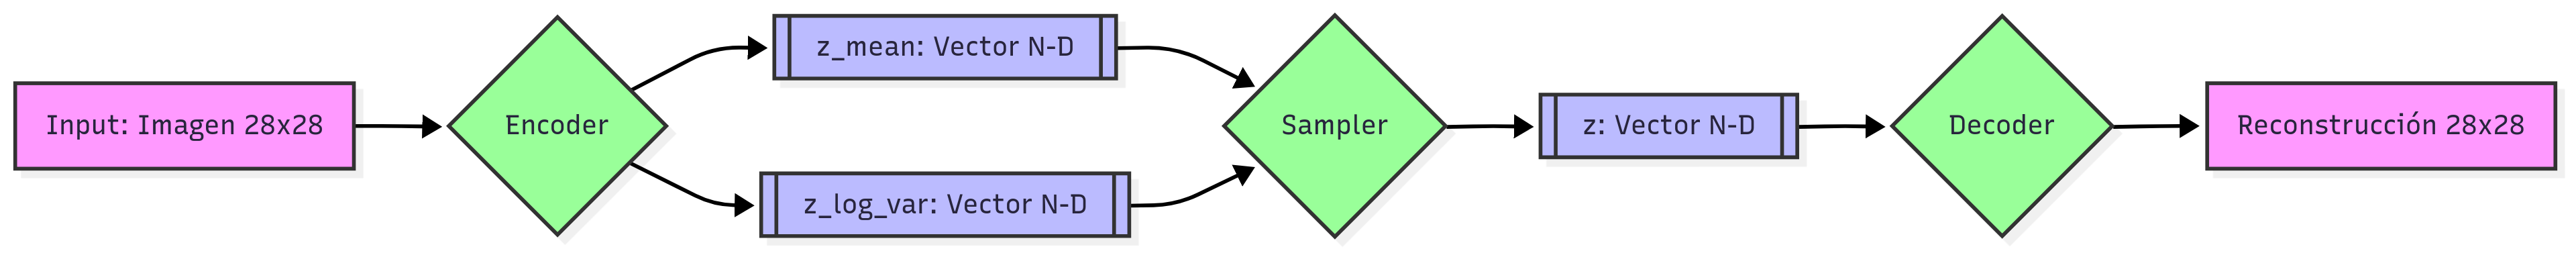

## Define el codificador
El bloque decodificador utiliza capas convolucionales para extraer características.
Aplana las características y las pasa por una capa densa. Produce dos salidas: z_mean y z_log_var, que representan la media y el logaritmo de la varianza del espacio latente.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ipywidgets import interact
from matplotlib import pyplot as plt

# espacio de dimensiones latentes
latent_dim = 3

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

2025-07-03 22:13:46.860533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 22:13:46.915435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 22:13:46.915510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 22:13:46.917374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-03 22:13:46.917434: I external/local_xla/xla/stream_executor

In [4]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         51 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         51 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,110 (269.96 KB)

 Trainable params: 69,110 (269.96 KB)

 Non-trainable params: 0 (0.00 B)

## Define funcion de muestreo
Utiliza z_mean y z_log_var para generar muestras del espacio latente e implementa una reparametrización para permitir el entrenamiento mediante retropropagación.

In [5]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size, z_size = tf.shape(z_mean)[0], tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Define el bloque decodificador

El bloque decodificador toma muestras del espacio latente como entrada.
Utiliza capas densas y convolucionales transpuestas para reconstruir la imagen original.

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [7]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

## Define el paso de entrenamiento y las metricas utilizando una clase
El autonecoder variable combina el codificador, decodificador y muestreador.
Implementa la lógica de entrenamiento en el método train_step.
Calcula dos tipos de pérdidas:

a. **Pérdida de reconstrucción**: Cuantifica la capacidad del modelo para reconstruir fielmente los datos de entrada.

b. **Pérdida KL (Kullback-Leibler Divergence)**: Cuantifica la divergencia entre la distribución latente y una distribución normal estándar.

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]


    def train_step(self, data):

        with tf.GradientTape() as tape: # GradientTape para registrar las operaciones para la diferenciación automática

            z_mean, z_log_var = self.encoder(data) # Codifica entrada y obtiene media y log-varianza del espacio latente

            z = self.sampler(z_mean, z_log_var)    # Muestrea del espacio latente usando reparametrización

            reconstruction = decoder(z)            # Reconstruye la entrada usando el decoder

            # Calcula la pérdida de reconstrucción (binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Calcula Kullback-Leibler divergence
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss # Combina y obtiene pérdida total

        grads = tape.gradient(total_loss, self.trainable_weights)  # Calcula los gradientes

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  # Aplica gradientes para actualizar los pesos

        # Actualiza las métricas de pérdida
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Retorna diccionario con los valores de las métricas
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Entrenar el modelo con MNIST

In [9]:
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005))
vae_model.fit(x_train, epochs=30, batch_size=256)

2025-07-03 22:13:55.219641: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2025-07-03 22:13:56.649982: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/30


I0000 00:00:1751580839.197825   71446 service.cc:145] XLA service 0x7f99240018b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751580839.197964   71446 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-03 22:13:59.279389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-03 22:13:59.781347: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  7/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - kl_loss: 4.3590 - reconstruction_loss: 493.0692 - total_loss: 497.4281    

I0000 00:00:1751580848.101985   71446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - kl_loss: 2.5835 - reconstruction_loss: 245.3374 - total_loss: 247.9209
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - kl_loss: 2.1092 - reconstruction_loss: 183.7316 - total_loss: 185.8407
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - kl_loss: 3.3039 - reconstruction_loss: 157.7945 - total_loss: 161.0984
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - kl_loss: 3.7283 - reconstruction_loss: 142.3724 - total_loss: 146.1007
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - kl_loss: 3.7263 - reconstruction_loss: 138.0543 - total_loss: 141.7806
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - kl_loss: 3.7386 - reconstruction_loss: 135.4175 - total_loss: 139.1561
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 3.7466 - reconstruction_loss: 134.2002 - total_loss: 137.9467
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 3.7605 - reconstruction_loss: 132.6185 - total_loss: 136.3790
Epoch 9

### Guarda codificador y decodificador para recrear el VAE sin entrenarlo

In [10]:
vae_model.encoder.save(MODELOS_DIR + 'VAE_MNIST_encoder_3d.keras')
vae_model.decoder.save(MODELOS_DIR + 'VAE_MNIST_decoder_3d.keras')

### Recupera codificador y decodificador para recrear el modelo VAE

In [11]:
encoder = keras.models.load_model(MODELOS_DIR + 'VAE_MNIST_encoder_3d.keras')
decoder = keras.models.load_model(MODELOS_DIR + 'VAE_MNIST_decoder_3d.keras')

vae = VAE(encoder, decoder)

## Muestra la grilla de imágenes generadas a partir del espacio latente


Generando gráficos


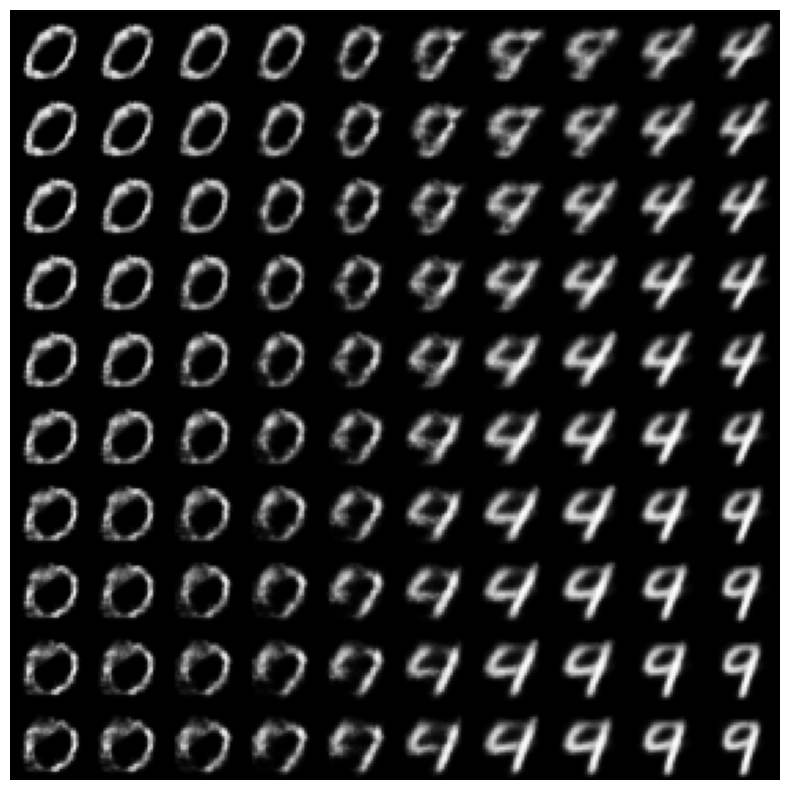

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def dibujar_espacio_latente(vae, n=30, latent_dim=2):
    digit_size = 28  # Tamaño de cada dígito
    scale = 1        # Escala para el espacio latente
    figure = np.zeros((digit_size * n, digit_size * n))  # matriz para almacenar las imágenes generadas

    # Puntos en el espacio latente a lo largo de los ejes X e Y
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]  # Invierte para una visualización más intuitiva

    # Iterar sobre los puntos en el espacio latente
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 1]])  # Generar una muestra en el espacio latente
            x_decoded = vae.decoder.predict(z_sample, verbose=0)  # Decodificar la muestra para generar una imagen
            digit = x_decoded[0].squeeze()  # Eliminar la dimensión extra y obtener una matriz 2D
            # Reorganizar la imagen generada al tamaño del dígito y almacenarla en la matriz
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    # Muestra matriz de imágenes generadas
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap=plt.cm.gray)  # Mostrar la matriz como una imagen
    plt.axis("off")  # Ocultar ejes y etiquetas
    plt.show()

print("Generando gráficos")
dibujar_espacio_latente(vae_model, n=10, latent_dim=3)

# Visualización interactiva del espacio latente

In [13]:
from ipywidgets import interact


def dibujar_digito_espacio_latente(vae, n=30, figsize=15):

    # Función para generar una imagen en función de coordenadas (xi, yi)
    def gen_img(xi, yi, zi):
        digit_size = 28

        z_sample = np.array([[xi, yi, zi]]) # Genera una muestra en el espacio latente

        # Decodificar la muestra para generar una imagen
        x_decoded = vae.decoder.predict(z_sample, verbose=0)

        return x_decoded[0]

    ESCALA = 100 # Escala barra de control

    # Función que muestra digito generado al interacturar con las barras
    def mostrar_imagen(x, y, z):
        # Invirtiendo 'y' para coincidir con la orientación gráfica
        plt.figure(figsize=(3,3))
        plt.imshow(gen_img(x/ESCALA, -y/ESCALA, -z/ESCALA), cmap=plt.cm.coolwarm, interpolation='nearest')
        plt.show()  # Mostrar la imagen generada
        plt.axis("off")  # Ocultar ejes y etiquetas

    interact(mostrar_imagen, x=(-ESCALA, ESCALA), y=(-ESCALA, ESCALA), z=(-ESCALA, ESCALA))

dibujar_digito_espacio_latente(vae_model)

interactive(children=(IntSlider(value=0, description='x', min=-100), IntSlider(value=0, description='y', min=-…

In [14]:
def dibujar_digito_espacio_latente(vae, num_imagenes=5, figsize=15):
    # Seleccionar varias imágenes aleatorias de MNIST
    indices = np.random.choice(len(x_test), size=num_imagenes, replace=False)
    original_imgs = x_test[indices]

    # Obtener las representaciones latentes de las imágenes originales
    z_means = []
    for img in original_imgs:
        z_mean, _ = vae.encoder.predict(np.expand_dims(img, axis=0), verbose=0)
        z_means.append(z_mean[0])

    # Función para generar imágenes modificadas
    def gen_imgs(xi, yi, zi):
        modified_imgs = []
        for original_z in z_means:
            # Crear vector latente modificado (relativo a cada imagen original)
            z_sample = np.array([[original_z[0] + xi/ESCALA,
                                 original_z[1] + yi/ESCALA,
                                 original_z[2] + zi/ESCALA]])

            # Decodificar la muestra para generar una imagen
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            modified_imgs.append(x_decoded[0])
        return modified_imgs

    ESCALA = 100
    FACTOR = 25.0

    # Función que muestra todas las imágenes originales y modificadas
    def mostrar_imagenes(x, y, z):
        # Calcular las imágenes modificadas
        modified_imgs = gen_imgs(FACTOR*x/ESCALA, FACTOR*y/ESCALA, FACTOR*z/ESCALA)

        # Configurar el tamaño de la figura según el número de imágenes
        fig, axes = plt.subplots(2, num_imagenes, figsize=(2*num_imagenes, 4))

        color_map = plt.cm.coolwarm

        # Mostrar todas las imágenes originales y modificadas
        for i in range(num_imagenes):
            # Mostrar imagen original
            axes[0, i].imshow(original_imgs[i].squeeze(), cmap='gray')
            axes[0, i].set_title(f"Original {i+1}")
            axes[0, i].axis("off")

            # Mostrar imagen modificada
            axes[1, i].imshow(modified_imgs[i].squeeze(), cmap=color_map)
            axes[1, i].set_title(f"Modificada {i+1}")
            axes[1, i].axis("off")

        plt.tight_layout()
        plt.show()

    # Crear sliders centrados en 0 para modificaciones
    interact(mostrar_imagenes,
             x=(-ESCALA, ESCALA),
             y=(-ESCALA, ESCALA),
             z=(-ESCALA, ESCALA))

# Llamar a la función con 7 imágenes (puedes cambiar este número)
dibujar_digito_espacio_latente(vae_model, num_imagenes=3)

interactive(children=(IntSlider(value=0, description='x', min=-100), IntSlider(value=0, description='y', min=-…

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from keras.datasets import mnist

(_, _), (x_test, _) = mnist.load_data()
x_test = x_test.astype('float32') / 255.
x_test = np.expand_dims(x_test, axis=-1)

def dibujar_digito_espacio_latente(vae, num_imagenes=5, figsize=15):
    # Selección de imágenes con diversidad
    indices = np.random.choice(len(x_test), size=num_imagenes*3, replace=False)
    selected = []
    for idx in indices:
        img = x_test[idx]
        if len(selected) < num_imagenes and np.mean(img) > 0.1 and np.mean(img) < 0.9:
            selected.append(img)
        if len(selected) == num_imagenes:
            break
    original_imgs = np.array(selected)

    # Obtener representaciones latentes
    z_means = []
    for img in original_imgs:
        z_mean, z_log_var = vae.encoder.predict(np.expand_dims(img, axis=0), verbose=0)
        z_means.append(z_mean[0])

    # Parámetros de control
    ESCALA = 100
    FACTOR = 15.0  # Reducido para cambios más sutiles
    IDENTITY_STRENGTH = 0.5  # Nuevo parámetro de control

    def gen_imgs(xi, yi, zi, identity_strength):
        modified_imgs = []
        for i, original_z in enumerate(z_means):
            # Modificación controlada por el parámetro de identidad
            modification = np.array([xi/ESCALA, yi/ESCALA, zi/ESCALA]) * (1 - identity_strength)
            z_sample = original_z + FACTOR * modification

            # Forzar a mantener características clave (opcional)
            if identity_strength > 0.7:
                z_sample = np.clip(z_sample, original_z - 0.5, original_z + 0.5)

            x_decoded = vae.decoder.predict(np.array([z_sample]), verbose=0)
            modified_imgs.append(x_decoded[0])
        return modified_imgs

    def mostrar_imagenes(x, y, z, identity_strength):
        modified_imgs = gen_imgs(x, y, z, identity_strength)

        fig, axes = plt.subplots(2, num_imagenes, figsize=(2*num_imagenes, 4))
        color_map = plt.cm.coolwarm

        for i in range(num_imagenes):
            # Original
            axes[0, i].imshow(original_imgs[i].squeeze(), cmap=color_map)
            axes[0, i].set_title(f"Original {i+1}")
            axes[0, i].axis("off")

            # Modificada
            axes[1, i].imshow(modified_imgs[i].squeeze(), cmap=color_map)
            axes[1, i].set_title(f"Mod {i+1}")
            axes[1, i].axis("off")

        plt.suptitle(f"Identity Strength: {identity_strength:.1f}", y=1.05)
        plt.tight_layout()
        plt.show()

    # Interfaz con control adicional
    interact(mostrar_imagenes,
             x=FloatSlider(min=-ESCALA, max=ESCALA, step=1, value=0, description="X"),
             y=FloatSlider(min=-ESCALA, max=ESCALA, step=1, value=0, description="Y"),
             z=FloatSlider(min=-ESCALA, max=ESCALA, step=1, value=0, description="Z"),
             identity_strength=FloatSlider(min=0, max=1, step=0.1, value=0.5,
                                         description="Mantener identidad"))

dibujar_digito_espacio_latente(vae_model, num_imagenes=3)

interactive(children=(FloatSlider(value=0.0, description='X', min=-100.0, step=1.0), FloatSlider(value=0.0, de…